# Fine-tuning for Video Classification with 🤗 Transformers

This notebook shows how to fine-tune a pre-trained Vision model for Video Classification on a custom dataset. The idea is to add a randomly initialized classification head on top of a pre-trained encoder and fine-tune the model altogether on a labeled dataset.


## Dataset

This notebook uses a subset of the [UCF-101 dataset](https://www.crcv.ucf.edu/data/UCF101.php). We'll be using a subset of the dataset to keep the runtime of the tutorial short. The subset was prepared using [this notebook](https://drive.google.com/file/d/1tTScjnyiKrBz84jKe1H_hPGGXffAZuxX/view?usp=sharing) following [this guide](https://www.tensorflow.org/tutorials/load_data/video). 

## Model

We'll fine-tune the [VideoMAE model](https://huggingface.co/docs/transformers/model_doc/videomae), which was pre-trained on the [Kinetics 400 dataset](https://www.deepmind.com/open-source/kinetics). You can find the other variants of VideoMAE available on 🤗 Hub [here](https://huggingface.co/models?search=videomae). You can also extend this notebook to use other video models such as [X-CLIP](https://huggingface.co/docs/transformers/model_doc/xclip#transformers.XCLIPVisionModel). 

**Note** that for models where there's no classification head already available you'll have to manually attach it (randomly initialized). But this is not the case for VideoMAE since we already have a [`VideoMAEForVideoClassification`](https://huggingface.co/docs/transformers/model_doc/xclip#transformers.XCLIPVisionModel) class.

## Data preprocessing

This notebook leverages [TorchVision's](https://pytorch.org/vision/stable/transforms.html) and [PyTorchVideo's](https://pytorchvideo.org/) transforms for applying data preprocessing transformations including data augmentation.

---

Depending on the model and the GPU you are using, you might need to adjust the batch size to avoid out-of-memory errors. Set those two parameters, then the rest of the notebook should run smoothly.

In [ ]:
model_ckpt = "MCG-NJU/videomae-base" # pre-trained model from which to fine-tune
batch_size = 8 # batch size for training and evaluation

Before we start, let's install the `pytorchvideo`, `transformers`, and `evaluate` libraries.

In [ ]:
!pip install pytorchvideo transformers evaluate -q

     |████████████████████████████████| 132 kB 4.9 MB/s 
     |████████████████████████████████| 5.5 MB 51.0 MB/s 
     |████████████████████████████████| 72 kB 1.6 MB/s 
     |████████████████████████████████| 50 kB 7.3 MB/s 
     |████████████████████████████████| 30.7 MB 1.2 MB/s 
     |████████████████████████████████| 42 kB 1.1 MB/s 
     |████████████████████████████████| 7.6 MB 48.7 MB/s 
     |████████████████████████████████| 163 kB 89.3 MB/s 
     |████████████████████████████████| 115 kB 85.3 MB/s 
     |████████████████████████████████| 441 kB 85.1 MB/s 
     |████████████████████████████████| 212 kB 53.0 MB/s 
     |████████████████████████████████| 95 kB 5.6 MB/s 
     |████████████████████████████████| 127 kB 88.8 MB/s 
     |████████████████████████████████| 115 kB 86.0 MB/s 


If you're opening this notebook locally, make sure your environment has an install from the last version of those libraries.

To be able to share your model with the community, there are a few more steps to follow.

First you have to store your authentication token from the Hugging Face website (sign up [here](https://huggingface.co/join) if you haven't already!) then execute the following cell and input your token:

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


Then you need to install Git-LFS to upload your model checkpoints:

In [ ]:
!git config --global credential.helper store

We also quickly upload some telemetry - this tells us which examples and software versions are getting used so we know where to prioritize our maintenance efforts. We don't collect (or care about) any personally identifiable information, but if you'd prefer not to be counted, feel free to skip this step or delete this cell entirely.

In [ ]:
from transformers import send_example_telemetry

send_example_telemetry("video_classification_notebook", framework="pytorch")

## Fine-tuning a model on a video classification task

In this notebook, we will see how to fine-tune one of the [🤗 Transformers](https://github.com/huggingface/transformers) vision models on a Video Classification dataset.

Given a video, the goal is to predict an appropriate class for it, like "archery".

### Loading the dataset

Here we first download the subset archive and un-archive it. 

In [ ]:
from huggingface_hub import hf_hub_download


hf_dataset_identifier = "sayakpaul/ucf101-subset"
filename = "UCF101_subset.tar.gz"
file_path = hf_hub_download(
    repo_id=hf_dataset_identifier, filename=filename, repo_type="dataset"
)

Downloading:   0%|          | 0.00/171M [00:00<?, ?B/s]

In [ ]:
!tar xf {file_path}

Now, let's investigate what is inside the archive.

In [ ]:
dataset_root_path = "UCF101_subset"

!find {dataset_root_path} | head -5

UCF101_subset
UCF101_subset/val
UCF101_subset/val/BasketballDunk
UCF101_subset/val/BasketballDunk/v_BasketballDunk_g05_c05.avi
UCF101_subset/val/BasketballDunk/UCF101


Broadly, `dataset_root_path` is organized like so:

```bash
UCF101_subset/
    train/
        BandMarching/
            video_1.mp4
            video_2.mp4
            ...
        Archery
            video_1.mp4
            video_2.mp4
            ...
        ...
    val/
        BandMarching/
            video_1.mp4
            video_2.mp4
            ...
        Archery
            video_1.mp4
            video_2.mp4
            ...
        ...
    test/
        BandMarching/
            video_1.mp4
            video_2.mp4
            ...
        Archery
            video_1.mp4
            video_2.mp4
            ...
        ...
```

Let's now count the number of total videos we have. 

In [ ]:
import pathlib

dataset_root_path = pathlib.Path(dataset_root_path)

In [ ]:
video_count_train = len(list(dataset_root_path.glob("train/*/*.avi")))
video_count_val = len(list(dataset_root_path.glob("val/*/*.avi")))
video_count_test = len(list(dataset_root_path.glob("test/*/*.avi")))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 405


In [ ]:
all_video_file_paths = (
    list(dataset_root_path.glob("train/*/*.avi"))
    + list(dataset_root_path.glob("val/*/*.avi"))
    + list(dataset_root_path.glob("test/*/*.avi"))
)
all_video_file_paths[:5]

[PosixPath('UCF101_subset/train/BasketballDunk/v_BasketballDunk_g21_c03.avi'),
 PosixPath('UCF101_subset/train/BasketballDunk/v_BasketballDunk_g20_c05.avi'),
 PosixPath('UCF101_subset/train/BasketballDunk/v_BasketballDunk_g09_c02.avi'),
 PosixPath('UCF101_subset/train/BasketballDunk/v_BasketballDunk_g10_c01.avi'),
 PosixPath('UCF101_subset/train/BasketballDunk/v_BasketballDunk_g19_c03.avi')]

The video paths, when `sorted`, appear like so:

```py
...
'UCF101_subset/train/ApplyEyeMakeup/v_ApplyEyeMakeup_g07_c04.avi',
'UCF101_subset/train/ApplyEyeMakeup/v_ApplyEyeMakeup_g07_c06.avi',
'UCF101_subset/train/ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c01.avi',
'UCF101_subset/train/ApplyEyeMakeup/v_ApplyEyeMakeup_g09_c02.avi',
'UCF101_subset/train/ApplyEyeMakeup/v_ApplyEyeMakeup_g09_c06.avi'
...
 ```

We notice that there are video clips belonging to the same group / scene where group is denoted by `g` in the video file paths. `v_ApplyEyeMakeup_g07_c04.avi` and `v_ApplyEyeMakeup_g07_c06.avi`, for example.


 For the validation and evaluation splits, we wouldn't want to have video clips from the same group / scene to prevent [data leakage](https://www.kaggle.com/code/alexisbcook/data-leakage). The subset that we're using in this tutorial takes this information into account.

Next up, we derive the set of labels we have in the dataset. Let's also create two dictionaries that'll be helpful when initializing the model:

* `label2id`: maps the class names to integers.
* `id2label`: maps the integers to class names. 

In [ ]:
class_labels = sorted({str(path).split("/")[2] for path in all_video_file_paths})
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"Unique classes: {list(label2id.keys())}.")

Unique classes: ['ApplyEyeMakeup', 'ApplyLipstick', 'Archery', 'BabyCrawling', 'BalanceBeam', 'BandMarching', 'BaseballPitch', 'Basketball', 'BasketballDunk', 'BenchPress'].


We've got 10 unique classes. For each class we have 30 videos in the training set. 

### Loading the model

In the next cell, we initialize a video classification model where the encoder is initialized with the pre-trained parameters and the classification head is randomly initialized. We also initialize the feature extractor associated to the model. This will come in handy during writing the preprocessing pipeline for our dataset.

In [ ]:
from transformers import VideoMAEFeatureExtractor, VideoMAEForVideoClassification


feature_extractor = VideoMAEFeatureExtractor.from_pretrained(model_ckpt)
model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

Downloading:   0%|          | 0.00/271 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/725 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/377M [00:00<?, ?B/s]

Some weights of the model checkpoint at MCG-NJU/videomae-base were not used when initializing VideoMAEForVideoClassification: ['decoder.decoder_layers.2.attention.output.dense.bias', 'decoder.norm.weight', 'decoder.decoder_layers.0.attention.output.dense.weight', 'mask_token', 'decoder.decoder_layers.2.attention.attention.q_bias', 'decoder.decoder_layers.3.output.dense.weight', 'decoder.decoder_layers.0.output.dense.weight', 'decoder.decoder_layers.0.layernorm_after.bias', 'decoder.decoder_layers.2.layernorm_after.bias', 'decoder.decoder_layers.0.layernorm_after.weight', 'decoder.decoder_layers.0.layernorm_before.weight', 'decoder.decoder_layers.3.layernorm_after.bias', 'decoder.decoder_layers.0.attention.attention.key.weight', 'decoder.decoder_layers.3.attention.attention.v_bias', 'decoder.decoder_layers.2.attention.attention.v_bias', 'decoder.decoder_layers.0.layernorm_before.bias', 'decoder.decoder_layers.0.attention.attention.value.weight', 'decoder.decoder_layers.1.layernorm_after

The warning is telling us we are throwing away some weights (e.g. the weights and bias of the `classifier` layer) and randomly initializing some other (the weights and bias of a new `classifier` layer). This is expected in this case, because we are adding a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

**Note** that [this checkpoint](https://huggingface.co/MCG-NJU/videomae-base-finetuned-kinetics) leads to better performance on this task as the checkpoint was obtained fine-tuning on a similar downstream task having considerable domain overlap. You can check out [this checkpoint](https://huggingface.co/sayakpaul/videomae-base-finetuned-kinetics-finetuned-ucf101-subset) which was obtained by fine-tuning `MCG-NJU/videomae-base-finetuned-kinetics` and it obtains much better performance.  

### Constructing the datasets for training

For preprocessing the videos, we'll leverage the [PyTorch Video library](https://pytorchvideo.org/). We start by importing the dependencies we need. 

In [ ]:
import pytorchvideo.data

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

For the training dataset transformations, we use a combination of uniform temporal subsampling, pixel normalization, random cropping, and random horizontal flipping. For the validation and evaluation dataset transformations, we keep the transformation chain the same except for random cropping and horizontal flipping. To learn more about the details of these transformations check out the [official documentation of PyTorch Video](https://pytorchvideo.org).  

We'll use the `feature_extractor` associated with the pre-trained model to obtain the following information:

* Image mean and standard deviation with which the video frame pixels will be normalized.
* Spatial resolution to which the video frames will be resized.

In [ ]:
import os

mean = feature_extractor.image_mean
std = feature_extractor.image_std
resize_to = feature_extractor.size

num_frames_to_sample = model.config.num_frames
sample_rate = 4
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps


# Training dataset transformations.
train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    RandomShortSideScale(min_size=256, max_size=320),
                    RandomCrop(resize_to),
                    RandomHorizontalFlip(p=0.5),
                ]
            ),
        ),
    ]
)
# Training dataset.
train_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "train"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    decode_audio=False,
    transform=train_transform,
)

# Validation and evaluation datasets' transformations.
val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize((resize_to, resize_to)),
                ]
            ),
        ),
    ]
)

# Validation and evaluation datasets.
val_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "val"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)
test_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "test"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

**Note**: The above dataset pipelines are taken from the [official PyTorch Video example](https://pytorchvideo.org/docs/tutorial_classification#dataset). We're using the [`pytorchvideo.data.Ucf101()`](https://pytorchvideo.readthedocs.io/en/latest/api/data/data.html#pytorchvideo.data.Ucf101) function because it's tailored for the UCF-101 dataset. Under the hood, it returns a [`pytorchvideo.data.labeled_video_dataset.LabeledVideoDataset`](https://pytorchvideo.readthedocs.io/en/latest/api/data/data.html#pytorchvideo.data.LabeledVideoDataset) object. `LabeledVideoDataset` class is the base class for all things video in the PyTorch Video dataset. So, if you wanted to use a custom dataset not supported off-the-shelf by PyTorch Video, you can extend the `LabeledVideoDataset` class accordingly. Refer to the `data` API [documentation to](https://pytorchvideo.readthedocs.io/en/latest/api/data/data.html) learn more. Also, if your dataset follows a similar structure (as shown above), then using the `pytorchvideo.data.Ucf101()` should work just fine. 

In [ ]:
# We can access the `num_videos` argument to know the number of videos we have in the
# dataset.
train_dataset.num_videos, val_dataset.num_videos, test_dataset.num_videos

(300, 30, 75)

Let's now take a preprocessed video from the dataset and investigate it. 

In [ ]:
sample_video = next(iter(train_dataset))
sample_video.keys()

dict_keys(['video', 'video_name', 'video_index', 'clip_index', 'aug_index', 'label'])

In [ ]:
def investigate_video(sample_video):
    """Utility to investigate the keys present in a single video sample."""
    for k in sample_video:
        if k == "video":
            print(k, sample_video["video"].shape)
        else:
            print(k, sample_video[k])

    print(f"Video label: {id2label[sample_video[k]]}")


investigate_video(sample_video)

video torch.Size([3, 16, 224, 224])
video_name v_Basketball_g01_c01.avi
video_index 210
clip_index 0
aug_index 0
label 7
Video label: Basketball


We can also visualize the preprocessed videos for easier debugging. 

In [ ]:
import imageio
import numpy as np
from IPython.display import Image


def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)


def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.
    
    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename


def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

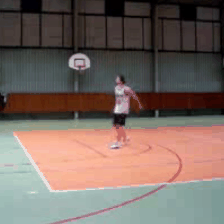

In [ ]:
video_tensor = sample_video["video"]
display_gif(video_tensor)

### Training the model

We'll leverage [`Trainer`](https://huggingface.co/docs/transformers/main_classes/trainer) from  🤗 Transformers for training the model. To instantiate a `Trainer`, we will need to define the training configuration and an evaluation metric. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to configure the training. It requires an output folder name, which will be used to save the checkpoints of the model. It also helps sync all the information in the model repository on 🤗 Hub.

Most of the training arguments are pretty self-explanatory, but one that is quite important here is `remove_unused_columns=False`. This one will drop any features not used by the model's call function. By default it's `True` because usually it's ideal to drop unused feature columns, making it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('video' in particular) in order to create `pixel_values` (which is a mandatory key our model expects in its inputs).

In [ ]:
from transformers import TrainingArguments, Trainer

model_name = model_ckpt.split("/")[-1]
new_model_name = f"{model_name}-finetuned-ucf101-subset"
num_epochs = 4

args = TrainingArguments(
    new_model_name,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    max_steps=(train_dataset.num_videos // batch_size) * num_epochs,
)

There's no need to define `max_steps` when instantiating `TrainingArguments`. Since the dataset returned by `pytorchvideo.data.Ucf101()` doesn't implement the `__len__()` method we had to specify `max_steps`.  

Next, we need to define a function for how to compute the metrics from the predictions, which will just use the `metric` we'll load now. The only preprocessing we have to do is to take the argmax of our predicted logits:

In [ ]:
import evaluate

metric = evaluate.load("accuracy")

In [ ]:
# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions."""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

**A note on evaluation**:

In the [VideoMAE paper](https://arxiv.org/abs/2203.12602), the authors use the following evaluation strategy. They evaluate the model on several clips from test videos and apply different crops to those clips and report the aggregate score. However, in the interest of simplicity and brevity, we don't consider that in this tutorial.

We also define a `collate_fn`, which will be used to batch examples together.
Each batch consists of 2 keys, namely `pixel_values` and `labels`.

In [ ]:
import torch


def collate_fn(examples):
    """The collation function to be used by `Trainer` to prepare data batches."""
    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

Then we just need to pass all of this along with our datasets to the `Trainer`:

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

Cloning https://huggingface.co/sayakpaul/videomae-base-finetuned-ucf101-subset into local empty directory.


Download file pytorch_model.bin:   0%|          | 1.47k/329M [00:00<?, ?B/s]

Download file runs/Nov10_07-25-30_8182e899e964/events.out.tfevents.1668065304.8182e899e964.107.0:  48%|####8  …

Download file training_args.bin: 100%|##########| 3.36k/3.36k [00:00<?, ?B/s]

Download file runs/Nov10_07-25-30_8182e899e964/1668065304.7947109/events.out.tfevents.1668065304.8182e899e964.…

Download file runs/Nov10_07-39-57_8182e899e964/events.out.tfevents.1668066010.8182e899e964.742.0:  23%|##2    …

Clean file runs/Nov10_07-25-30_8182e899e964/events.out.tfevents.1668065304.8182e899e964.107.0:  14%|#3        …

Download file runs/Nov09_01-44-16_588d19775fbb/1667958337.1126697/events.out.tfevents.1667958337.588d19775fbb.…

Clean file training_args.bin:  30%|##9       | 1.00k/3.36k [00:00<?, ?B/s]

Download file runs/Nov09_01-44-16_588d19775fbb/events.out.tfevents.1667958337.588d19775fbb.280.0:  48%|####8  …

Download file runs/Nov10_07-39-57_8182e899e964/1668066010.4314957/events.out.tfevents.1668066010.8182e899e964.…

Clean file runs/Nov10_07-25-30_8182e899e964/1668065304.7947109/events.out.tfevents.1668065304.8182e899e964.107…

Clean file runs/Nov10_07-39-57_8182e899e964/events.out.tfevents.1668066010.8182e899e964.742.0:  13%|#2        …

Clean file runs/Nov09_01-44-16_588d19775fbb/1667958337.1126697/events.out.tfevents.1667958337.588d19775fbb.280…

Clean file runs/Nov09_01-44-16_588d19775fbb/events.out.tfevents.1667958337.588d19775fbb.280.0:  14%|#3        …

Clean file runs/Nov10_07-39-57_8182e899e964/1668066010.4314957/events.out.tfevents.1668066010.8182e899e964.742…

Download file runs/Nov10_07-39-57_8182e899e964/events.out.tfevents.1668066300.8182e899e964.742.2: 100%|#######…

Clean file runs/Nov10_07-39-57_8182e899e964/events.out.tfevents.1668066300.8182e899e964.742.2: 100%|##########…

Download file runs/Nov09_01-44-16_588d19775fbb/events.out.tfevents.1667958570.588d19775fbb.280.2: 100%|#######…

Clean file runs/Nov09_01-44-16_588d19775fbb/events.out.tfevents.1667958570.588d19775fbb.280.2: 100%|##########…

Clean file pytorch_model.bin:   0%|          | 1.00k/329M [00:00<?, ?B/s]

max_steps is given, it will override any value given in num_train_epochs


You might wonder why we pass along the `feature_extractor` as a tokenizer when we already preprocessed our data. This is only to make sure the feature extractor configuration file (stored as JSON) will also be uploaded to the repo on the hub.

Now we can finetune our model by calling the `train` method:

In [ ]:
train_results = trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1184
  Num Epochs = 9223372036854775807
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 148
  Number of trainable parameters = 86234890


Epoch,Training Loss,Validation Loss,Accuracy
0,2.137400,1.741283,0.571429
1,0.794900,0.774667,0.800000
2,0.427900,0.405341,0.914286
3,0.291000,0.342882,0.928571


***** Running Evaluation *****
  Num examples: Unknown
  Batch size = 8
Saving model checkpoint to videomae-base-finetuned-ucf101-subset/checkpoint-38
Configuration saved in videomae-base-finetuned-ucf101-subset/checkpoint-38/config.json
Model weights saved in videomae-base-finetuned-ucf101-subset/checkpoint-38/pytorch_model.bin
Feature extractor saved in videomae-base-finetuned-ucf101-subset/checkpoint-38/preprocessor_config.json
Feature extractor saved in videomae-base-finetuned-ucf101-subset/preprocessor_config.json
***** Running Evaluation *****
  Num examples: Unknown
  Batch size = 8
Saving model checkpoint to videomae-base-finetuned-ucf101-subset/checkpoint-76
Configuration saved in videomae-base-finetuned-ucf101-subset/checkpoint-76/config.json
Model weights saved in videomae-base-finetuned-ucf101-subset/checkpoint-76/pytorch_model.bin
Feature extractor saved in videomae-base-finetuned-ucf101-subset/checkpoint-76/preprocessor_config.json
***** Running Evaluation *****
  Num exa

We can check with the `evaluate` method that our `Trainer` did reload the best model properly (if it was not the last one):

In [ ]:
trainer.evaluate(test_dataset)

***** Running Evaluation *****
  Num examples: Unknown
  Batch size = 8


{'eval_loss': 0.3992488980293274,
 'eval_accuracy': 0.864516129032258,
 'eval_runtime': 14.1288,
 'eval_samples_per_second': 10.971,
 'eval_steps_per_second': 1.416,
 'epoch': 3.23}

In [ ]:
trainer.save_model()
test_results = trainer.evaluate(test_dataset)
trainer.log_metrics("test", test_results)
trainer.save_metrics("test", test_results)
trainer.save_state()

Saving model checkpoint to videomae-base-finetuned-ucf101-subset
Configuration saved in videomae-base-finetuned-ucf101-subset/config.json
Model weights saved in videomae-base-finetuned-ucf101-subset/pytorch_model.bin
Feature extractor saved in videomae-base-finetuned-ucf101-subset/preprocessor_config.json
Saving model checkpoint to videomae-base-finetuned-ucf101-subset
Configuration saved in videomae-base-finetuned-ucf101-subset/config.json
Model weights saved in videomae-base-finetuned-ucf101-subset/pytorch_model.bin
Feature extractor saved in videomae-base-finetuned-ucf101-subset/preprocessor_config.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.34k/329M [00:00<?, ?B/s]

Upload file runs/Nov10_08-33-15_c4cf3c5cebad/events.out.tfevents.1668069624.c4cf3c5cebad.106.2: 100%|#########…

Upload file runs/Nov10_08-33-15_c4cf3c5cebad/events.out.tfevents.1668069370.c4cf3c5cebad.106.0:  42%|####1    …

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/sayakpaul/videomae-base-finetuned-ucf101-subset
   7e47bcb..9ad4c6d  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/sayakpaul/videomae-base-finetuned-ucf101-subset
   7e47bcb..9ad4c6d  main -> main

To https://huggingface.co/sayakpaul/videomae-base-finetuned-ucf101-subset
   9ad4c6d..e3ebcb5  main -> main

   9ad4c6d..e3ebcb5  main -> main

***** Running Evaluation *****
  Num examples: Unknown
  Batch size = 8


***** test metrics *****
  epoch                   =       3.23
  eval_accuracy           =     0.8645
  eval_loss               =     0.3992
  eval_runtime            = 0:00:13.79
  eval_samples_per_second =     11.233
  eval_steps_per_second   =      1.449


You can now upload the result of the training to the Hub, just execute this instruction (note that the Trainer will automatically create a model card as well as Tensorboard logs - see the "Training metrics" tab - amazing isn't it?):

In [ ]:
trainer.push_to_hub()

Saving model checkpoint to videomae-base-finetuned-ucf101-subset
Configuration saved in videomae-base-finetuned-ucf101-subset/config.json
Model weights saved in videomae-base-finetuned-ucf101-subset/pytorch_model.bin
Feature extractor saved in videomae-base-finetuned-ucf101-subset/preprocessor_config.json


Upload file runs/Nov10_08-33-15_c4cf3c5cebad/events.out.tfevents.1668069624.c4cf3c5cebad.106.2: 100%|#########…

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/sayakpaul/videomae-base-finetuned-ucf101-subset
   e3ebcb5..60d2897  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/sayakpaul/videomae-base-finetuned-ucf101-subset
   e3ebcb5..60d2897  main -> main



'https://huggingface.co/sayakpaul/videomae-base-finetuned-ucf101-subset/commit/60d28970cff3c61201790c839f35a17936df4022'

Now that our model is trained, let's use it to run inference on a video from `test_dataset`. 

## Inference

Let's load the trained model checkpoint and fetch a video from `test_dataset`. 

In [ ]:
trained_model = VideoMAEForVideoClassification.from_pretrained(new_model_name)

loading configuration file videomae-base-finetuned-ucf101-subset/config.json
Model config VideoMAEConfig {
  "_name_or_path": "MCG-NJU/videomae-base",
  "architectures": [
    "VideoMAEForVideoClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "decoder_hidden_size": 384,
  "decoder_intermediate_size": 1536,
  "decoder_num_attention_heads": 6,
  "decoder_num_hidden_layers": 4,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "ApplyEyeMakeup",
    "1": "ApplyLipstick",
    "2": "Archery",
    "3": "BabyCrawling",
    "4": "BalanceBeam",
    "5": "BandMarching",
    "6": "BaseballPitch",
    "7": "Basketball",
    "8": "BasketballDunk",
    "9": "BenchPress"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "ApplyEyeMakeup": 0,
    "ApplyLipstick": 1,
    "Archery": 2,
    "BabyCrawling": 3,
    "BalanceBeam": 4,
    "BandMarching": 5,
    "BaseballPitch": 6,
    "Basketbal

In [ ]:
sample_test_video = next(iter(test_dataset))
investigate_video(sample_test_video)

video torch.Size([3, 16, 224, 224])
video_name v_BasketballDunk_g12_c05.avi
video_index 62
clip_index 0
aug_index 0
label 8
Video label: BasketballDunk


We then prepare the video as a `torch.Tensor` and run inference. 

In [ ]:
def run_inference(model, video):
    """Utility to run inference given a model and test video.
    
    The video is assumed to be preprocessed already.
    """
    # (num_frames, num_channels, height, width)
    perumuted_sample_test_video = video.permute(1, 0, 2, 3)

    inputs = {
        "pixel_values": perumuted_sample_test_video.unsqueeze(0),
        "labels": torch.tensor(
            [sample_test_video["label"]]
        ),  # this can be skipped if you don't have labels available.
    }
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model = model.to(device)

    # forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    return logits

In [ ]:
logits = run_inference(trained_model, sample_test_video["video"])

We can now check if the model got the prediction right. 

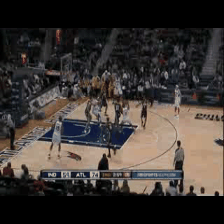

In [ ]:
display_gif(sample_test_video["video"])

In [ ]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: BasketballDunk


And it looks like it got it right!

You can also use this model to bring in your own videos. Check out [this Space](https://huggingface.co/spaces/sayakpaul/video-classification-ucf101-subset) to know more. The Space will also show you how to run inference for a single video file.

<br><div align=center>
    <img src="https://i.ibb.co/7nW4Rkn/sample-results.gif" width=700/>
</div>

## Next steps

Now that you've learned to train a well-performing video classification model on a custom dataset here is some homework for you:

* Increase the dataset size: include more classes and more samples per class. 
* Try out different hyperparameters to study how the model converges.
* Analyze the classes for which the model fails to perform well. 
* Try out a different video encoder.

Don't forget to share your models with the community =)